## Training

code and steps to train the 3D U-Net model

In [4]:
import os
import numpy as np
#import tensorflow as tf
import torch
from torch import nn
from matplotlib import pyplot as plt
import glob
import random
import pandas as pd

#### **Image Generators**:
Image generators for training and validation sets are defined using the custom data loader.

In [2]:
from custom_generator import imageLoader

In [76]:
train_img_dir = "BraTS2021_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2021_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2021_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2021_TrainingData/input_data_128/val/masks/"

train_img_list= sorted(os.listdir(train_img_dir))
train_mask_list = sorted(os.listdir(train_mask_dir))

val_img_list = sorted(os.listdir(val_img_dir))
val_mask_list = sorted(os.listdir(val_mask_dir))

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

now we test the generator...

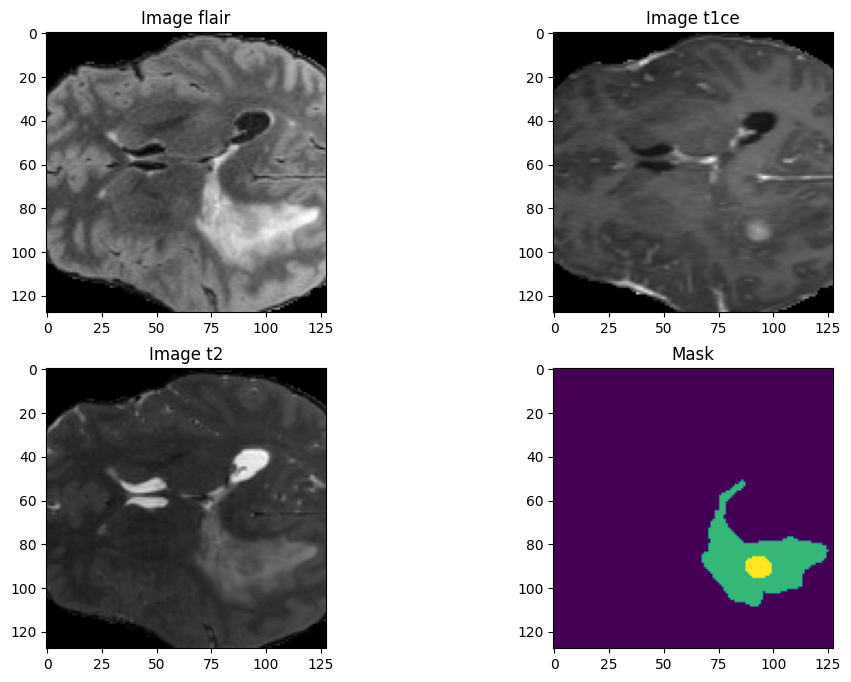

In [17]:
for img, msk in train_img_datagen:
    break  # Break after the first batch

img_num = random.randint(0,img.shape[0]-1) # a random image from the batch
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice = 70

# print(img.shape) --> torch.Size([2, 192, 192, 128, 3])
# print(test_img.shape) --> torch.Size([192, 192, 128, 3])

plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

**Loss Function, Metrics, and Optimizer**:
- (Multiclass) Dice Loss is defined as the loss functions. (we both tried with and without weights)
- (Multiclass) IOU (Intersection over Union) is initially used for evaluation. (then we also integrate metrics such as Sensitivity, Specificity, Precision and F1 Score)
- Adam optimizer is utilized for optimization.

In [18]:
class MultiClassDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiClassDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # inputs: [batch_size, num_classes, ...]
        # targets: [batch_size, num_classes, ...]

        dice_per_class = []
        for class_idx in range(inputs.size(1)):  # Iterate over classes
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]
            
            # Dice Loss for each class separately
            intersection = (class_inputs * class_targets).sum()
            dice = (2. * intersection + smooth) / (class_inputs.sum() + class_targets.sum() + smooth)
            dice_per_class.append(dice)

        # Average Dice Loss across all classes
        mean_dice_loss = torch.mean(torch.stack(dice_per_class))
        return 1 - mean_dice_loss
    

class MultiIoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(MultiIoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
          
        IoU_per_class = []
        for class_idx in range(inputs.size(1)):
            class_inputs = inputs[:, class_idx, ...]
            class_targets = targets[:, class_idx, ...]
        
            intersection = (class_inputs * class_targets).sum() # True Positive count
            total = (class_inputs + class_targets).sum()
            union = total - intersection  # mutually inclusive area of all labels & predictions 
        
            IoU = (intersection + smooth)/(union + smooth)
            IoU_per_class.append(IoU)

        mean_IoU_loss = torch.mean(torch.stack(IoU_per_class))
                
        return mean_IoU_loss # actually it should be 1-mean_IoU_loss but i am using it as an accuracy measure

In [19]:
def WeightedDiceLoss(input, target):
    smooth = 1.
    loss = 0.
    class_weights = [0.10, 0.35, 0.30, 0.25]
    for c in range(4):
           iflat = input[:,c,:,:,:].reshape(-1)
           tflat = target[:,c, ...].reshape(-1)
           intersection = (iflat * tflat).sum()

           w = class_weights[c]
           loss += w*(1 - ((2. * intersection + smooth) /
                             (iflat.sum() + tflat.sum() + smooth)))
    return loss

### Model Definition and Initialization

In [20]:
from simple3DUnet import UNet_3d
model = UNet_3d()

### Hyperparameters

In [ ]:
NUM_EPOCHS = 90
LR = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.to(DEVICE)

multi_dice = MultiClassDiceLoss()
multi_IoU = MultiIoULoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
from torch.cuda.amp import autocast, GradScaler
from transformers import get_linear_schedule_with_warmup

scaler = GradScaler()

num_warmup_steps = 10
num_training_steps = NUM_EPOCHS * len(train_img_datagen)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

## Training Loop

during training we use
- GRADIENT ACCUMULATION TECHNIQUE to simulate a larger batch size which we cannot afford
- MIXED PRECISION TRAINING (if CUDA is available) --> use of a lower-precision operations when training a model to make it run faster and decrease memory usage (some operations use torch.float16 datatype and others torch.float32)


In [ ]:
accumulation_steps = 8  # Set to the number of steps over which to accumulate gradients to simulate a larger batch size

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0

    current_lr = scheduler.optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate: {current_lr:.6f}")

    optimizer.zero_grad()

    for i, (images, masks) in enumerate(train_img_datagen):
        images = images.float().to(device=DEVICE)
        masks = masks.to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)

        with autocast():
            preds = model(torch.transpose(torch.transpose(torch.transpose(images, 1, -1), 2, -1), 2, -2))
            loss = multi_dice(preds, masks)
            loss = loss / accumulation_steps  # Normalize the loss

        scaler.scale(loss).backward()

        # Update the weights every `accumulation_steps`
        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)  # WEIGHTs UPDATE
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps  # Scale back the loss
        running_accuracy += multi_IoU(preds, masks).item()

    # If there are remaining gradients, update them as well
    if (i + 1) % accumulation_steps != 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(train_img_datagen)
    epoch_accuracy = running_accuracy / len(train_img_datagen)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"Train Loss: {epoch_loss:.4f} | Train Accuracy: {epoch_accuracy:.4f}")

    scheduler.step()

    # Save model checkpoints before 90 epochs
    if epoch in [30, 45, 60]:
        torch.save(model.state_dict(), f'models/brats_Unet3d_epoch{epoch}.pth')

# Save the trained model
torch.save(model.state_dict(), 'models/brats_Unet3d.pth')

## Validation on a random sample

- load the saved trained model
- take a random sample from validation set dataset (using custom generator we get a batch so we need to select randomly a sample from the batch)
- predict the mask using loaded model
- prepare the prediction, volume, target mask vectors to be displayed using matplotlib

In [27]:
modelLoad = UNet_3d()

modelLoad.load_state_dict(torch.load('models/brats_Unet3d_final.pth', map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [77]:
for imgs, msks in val_img_datagen:
    break

#print(imgs.shape, msks.shape) # --> torch.Size([2, 128, 128, 128, 3]) torch.Size([2, 128, 128, 128, 4])

img_num = random.randint(0, imgs.size(0)-1) # select a random sample from the batch
val_img = imgs[img_num].unsqueeze(0)
val_msk = msks[img_num].unsqueeze(0)

#print(val_img.shape, val_msk.shape) # --> torch.Size([1, 128, 128, 128, 3]) torch.Size([1, 128, 128, 128, 4])

In [45]:
val_pred = modelLoad(torch.transpose(torch.transpose(torch.transpose(val_img.float(), 1, -1), 2, -1), 2, -2))
#print(val_pred.shape) # --> torch.Size([1, 4, 128, 128, 128])
# where 4 is the number of clases (so prediction are in 1 hot encoding format)

In [47]:
DICE_SCORE = 1-multi_dice(val_pred, torch.transpose(torch.transpose(torch.transpose(val_msk, 1, -1), 2, -1), 2, -2))
print('DICE SCORE = ', DICE_SCORE.item())

DICE SCORE =  0.6226291060447693


In [48]:
val_pred = val_pred[0] # shape = torch.Size([4, 128, 128, 128])
val_pred = torch.transpose(torch.transpose(torch.transpose(val_pred, 0, -1), 0, 2), 1, 2) # shape = torch.Size([128, 128, 128, 4])
val_msk = val_msk[0] # shape = torch.Size([128, 128, 128, 4])

In [49]:
val_img = val_img[0]
val_img = val_img.cpu().numpy()

In [50]:
val_pred = val_pred.cpu().detach().numpy()
val_msk = val_msk.cpu().numpy()

val_msk=np.argmax(val_msk, axis=3)
val_pred = np.argmax(val_pred, axis=3)

In [51]:
val, counts = np.unique(val_pred, return_counts=True)
print('prediction', val, counts)

val, counts = np.unique(val_msk, return_counts=True)
print('mask', val, counts)

prediction [0 1 2 3] [2044472    3917   44238    4525]
mask [0 1 2 3] [2033843   10415   41615   11279]


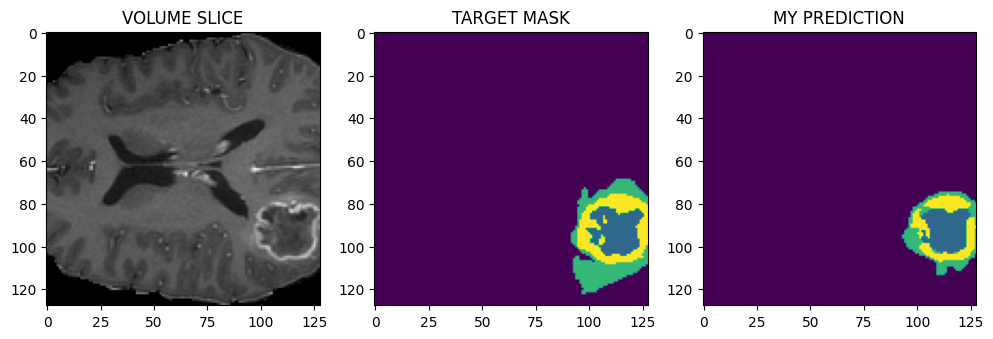

In [56]:
plt.figure(figsize=(12,6))

slice = 70

plt.subplot(131)
plt.title('VOLUME SLICE')
plt.imshow(val_img[:,:,70,1], cmap='gray')

plt.subplot(132)
plt.title('TARGET MASK')
plt.imshow(val_msk[:,:,70])

plt.subplot(133)
plt.title('MY PREDICTION')
plt.imshow(val_pred[:,:,70])

## Validation loop

we define the other accuracy metrics to rovide a more comprehensive understanding of the model's performance

In [78]:
def compute_multiclass_metrics(preds, masks, num_classes, threshold=0.5):
    preds = (preds > threshold).float()
    masks = masks.float()

    sensitivity_sum = 0
    specificity_sum = 0
    precision_sum = 0
    f1_score_sum = 0

    for c in range(num_classes):

        # every metric is calculated for each class separately
        # (as a pixel-wise classification task) and then averaged
        
        pred_c = preds[:, c, :, :, :]
        mask_c = masks[:, c, :, :, :]

        TP = (pred_c * mask_c).sum().item()  # True Positives
        TN = ((1 - pred_c) * (1 - mask_c)).sum().item()  # True Negatives
        FP = (pred_c * (1 - mask_c)).sum().item()  # False Positives
        FN = ((1 - pred_c) * mask_c).sum().item()  # False Negatives

        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        f1_score = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

        sensitivity_sum += sensitivity
        specificity_sum += specificity
        precision_sum += precision
        f1_score_sum += f1_score

    avg_sensitivity = sensitivity_sum / num_classes
    avg_specificity = specificity_sum / num_classes
    avg_precision = precision_sum / num_classes
    avg_f1_score = f1_score_sum / num_classes

    return avg_sensitivity, avg_specificity, avg_precision, avg_f1_score

VALIDATION LOOP

In [ ]:
with torch.no_grad():
    test_loss = 0
    test_acc = 0
    sensitivity_sum = 0
    specificity_sum = 0
    precision_sum = 0
    f1_score_sum = 0

    for images, masks in val_img_datagen:
        images = images.float().to(device=DEVICE)
        masks = masks.float().to(device=DEVICE)
        masks = torch.transpose(torch.transpose(torch.transpose(masks, 1, -1), 2, -1), 2, -2)

        preds = modelLoad(torch.transpose(torch.transpose(torch.transpose(images, 1, -1), 2, -1), 2, -2))

        loss = multi_dice(preds,masks)
        test_loss += loss.item()

        test_acc += multi_IoU(preds, masks).item()

        sensitivity, specificity, precision, f1_score = compute_multiclass_metrics(preds, masks, 4)
        sensitivity_sum += sensitivity
        specificity_sum += specificity
        precision_sum += precision
        f1_score_sum += f1_score

    # average
    test_loss /= len(val_img_datagen)
    test_acc /= len(val_img_datagen)
    sensitivity_sum /= len(val_img_datagen)
    specificity_sum /= len(val_img_datagen)
    precision_sum /= len(val_img_datagen)
    f1_score_sum /= len(val_img_datagen)

In [80]:
import pandas as pd

# Define the metrics
metrics = {
    "Metric": ["Dice Score", "IoU Score", "Sensitivity", "Specificity", "Precision", "F1 Score"],
    "Value": [1-test_loss, test_acc, sensitivity_sum, specificity_sum, precision_sum, f1_score_sum]
}

# Create a DataFrame
df_metrics = pd.DataFrame(metrics)

styled_df = df_metrics.style.set_table_styles(
    [{'selector': 'th',
      'props': [('background-color', '#101617'),
                ('font-weight', 'bold'),
                ('text-align', 'center')]},
     {'selector': 'td',
      'props': [('text-align', 'center')]}]
).set_properties(**{
    'border': '1px solid black',
    'padding': '6px'
}).set_caption("Model Performance")

styled_df

,Metric,Value
0,Dice Score,0.586508
1,IoU Score,0.476055
2,Sensitivity,0.595758
3,Specificity,0.929389
4,Precision,0.672609
5,F1 Score,0.589781
